<a href="https://colab.research.google.com/github/cesarorrr/AI-Class/blob/main/Ejemplo_predicci%C3%B3n_de_precios_vivienda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Librerías

In [22]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

# Modelado
# ==============================================================================
from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn import set_config
import multiprocessing

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

Datos

In [23]:
# Descarga de datos
# ==============================================================================
url = ("https://raw.githubusercontent.com/JoaquinAmatRodrigo/"
       "Estadistica-machine-learning-python/master/data/SaratogaHouses.csv")
datos = pd.read_csv(url, sep=",")

# Se renombran las columnas para que sean más descriptivas
datos.columns = ["precio", "metros_totales", "antiguedad", "precio_terreno",
                 "metros_habitables", "universitarios", "dormitorios",
                 "chimenea", "banyos", "habitaciones", "calefaccion",
                 "consumo_calefacion", "desague", "vistas_lago",
                 "nueva_construccion", "aire_acondicionado"]


Análisis exploratorio

In [24]:
# Tipo de cada columna
# ==============================================================================
# En pandas, el tipo "object" hace referencia a strings
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   precio              1728 non-null   int64  
 1   metros_totales      1728 non-null   float64
 2   antiguedad          1728 non-null   int64  
 3   precio_terreno      1728 non-null   int64  
 4   metros_habitables   1728 non-null   int64  
 5   universitarios      1728 non-null   int64  
 6   dormitorios         1728 non-null   int64  
 7   chimenea            1728 non-null   int64  
 8   banyos              1728 non-null   float64
 9   habitaciones        1728 non-null   int64  
 10  calefaccion         1728 non-null   object 
 11  consumo_calefacion  1728 non-null   object 
 12  desague             1728 non-null   object 
 13  vistas_lago         1728 non-null   object 
 14  nueva_construccion  1728 non-null   object 
 15  aire_acondicionado  1728 non-null   object 
dtypes: flo

In [25]:
# Número de datos ausentes por variable
# ==============================================================================
datos.isna().sum().sort_values()

precio                0
metros_totales        0
antiguedad            0
precio_terreno        0
metros_habitables     0
universitarios        0
dormitorios           0
chimenea              0
banyos                0
habitaciones          0
calefaccion           0
consumo_calefacion    0
desague               0
vistas_lago           0
nueva_construccion    0
aire_acondicionado    0
dtype: int64

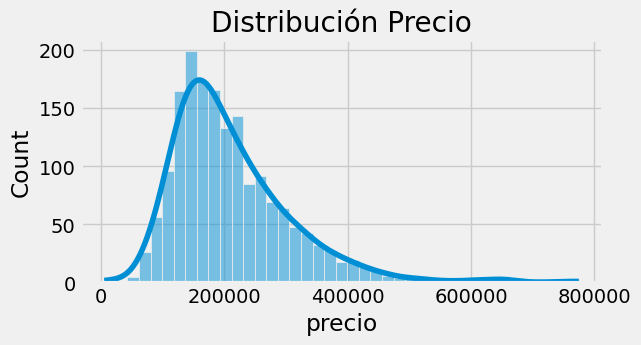

In [26]:
# Distribución variable respuesta
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
sns.histplot(data=datos, x='precio', kde=True,ax=ax)
ax.set_title("Distribución Precio")
ax.set_xlabel('precio');

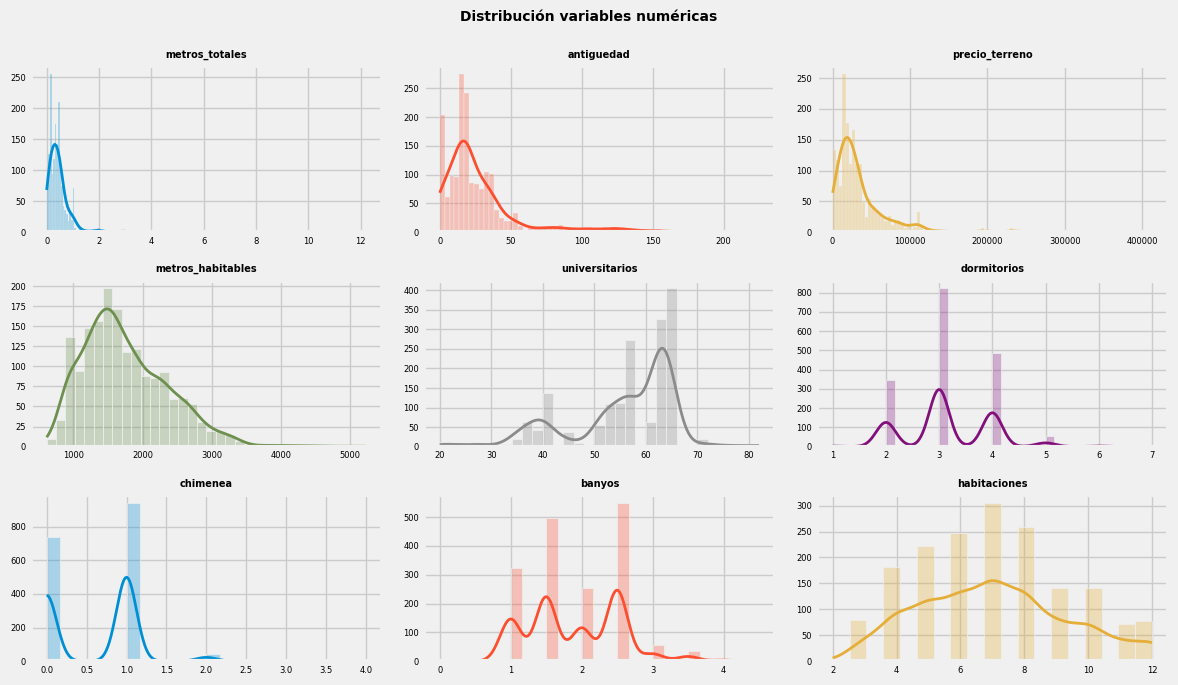

In [27]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 7))
axes = axes.flat
columnas_numeric = datos.select_dtypes(include=['float64', 'int']).columns
columnas_numeric = columnas_numeric.drop('precio')

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = datos,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")


fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");

In [28]:
# Valores observados de chimenea
# ==============================================================================
datos.chimenea = datos.chimenea.astype("str")
datos.chimenea.value_counts()

chimenea
1    942
0    740
2     42
4      2
3      2
Name: count, dtype: int64

In [29]:
# Variables cualitativas (tipo object)
# ==============================================================================
datos.select_dtypes(include=['object']).describe()

chimenea calefaccion consumo_calefacion            desague vistas_lago  \
count      1728        1728               1728               1728        1728   
unique        5           3                  3                  3           2   
top           1     hot air                gas  public/commercial          No   
freq        942        1121               1197               1213        1713   

       nueva_construccion aire_acondicionado  
count                1728               1728  
unique                  2                  2  
top                    No                 No  
freq                 1647               1093

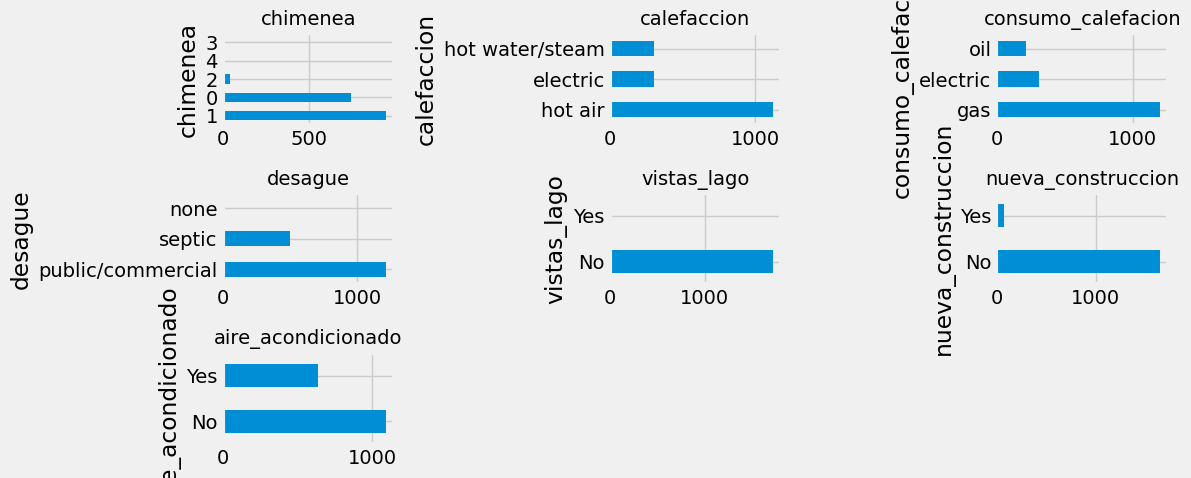

In [30]:
# Gráfico para cada variable cualitativa
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 5))
axes = axes.flat
columnas_object = datos.select_dtypes(include=['object']).columns

for i, colum in enumerate(columnas_object):
    datos[colum].value_counts().plot.barh(ax = axes[i])
    axes[i].set_title(colum, fontsize = 14)
    axes[i].set_xlabel("")

# Se eliminan los axes vacíos
for i in [7, 8]:
    fig.delaxes(axes[i])

fig.tight_layout()

In [32]:
dic_replace = {'2': "2_mas",
               '3': "2_mas",
               '4': "2_mas"}

datos['chimenea'] = datos['chimenea'] \
                     .map(dic_replace) \
                     .fillna(datos['chimenea'])
datos.chimenea.value_counts().sort_index()

chimenea
0        740
1        942
2_mas     46
Name: count, dtype: int64

División train y test

In [33]:
# Reparto de datos en train y test
# ==============================================================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop('precio', axis = 'columns'),
                                        datos['precio'],
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [34]:
print("Partición de entrenamento")
print("-----------------------")
display(y_train.describe())
display(X_train.describe())
display(X_train.describe(include = 'object'))
print(" ")

print("Partición de test")
print("-----------------------")
display(y_test.describe())
display(X_test.describe())
display(X_test.describe(include = 'object'))

Partición de entrenamento
-----------------------


count      1382.000000
mean     211436.516643
std       96846.639129
min       10300.000000
25%      145625.000000
50%      190000.000000
75%      255000.000000
max      775000.000000
Name: precio, dtype: float64

metros_totales   antiguedad  precio_terreno  metros_habitables  \
count     1382.000000  1382.000000     1382.000000        1382.000000   
mean         0.501331    27.494211    34232.141823        1755.940666   
std          0.671766    28.212721    35022.662319         621.262215   
min          0.000000     0.000000      200.000000         616.000000   
25%          0.170000    13.000000    15100.000000        1302.000000   
50%          0.370000    19.000000    25000.000000        1650.000000   
75%          0.540000    33.750000    39200.000000        2127.250000   
max          8.970000   201.000000   412600.000000        4856.000000   

       universitarios  dormitorios       banyos  habitaciones  
count     1382.000000  1382.000000  1382.000000   1382.000000  
mean        55.439942     3.165702     1.902677      7.073082  
std         10.356656     0.825487     0.660053      2.315395  
min         20.000000     1.000000     0.000000      2.000000  
25%         52.000000     3.000000     1.500000      5.000000  
50%         57.000000     3.000000     2.000000      7.000000  
75%         63.000000     4.000000     2.500000      9.000000  
max         82.000000     7.000000     4.500000     12.000000

chimenea calefaccion consumo_calefacion            desague vistas_lago  \
count      1382        1382               1382               1382        1382   
unique        3           3                  3                  3           2   
top           1     hot air                gas  public/commercial          No   
freq        741         915                972                970        1370   

       nueva_construccion aire_acondicionado  
count                1382               1382  
unique                  2                  2  
top                    No                 No  
freq                 1321                863

 
Partición de test
-----------------------


count       346.000000
mean     214084.395954
std      104689.155889
min        5000.000000
25%      139000.000000
50%      180750.000000
75%      271750.000000
max      670000.000000
Name: precio, dtype: float64

metros_totales  antiguedad  precio_terreno  metros_habitables  \
count      346.000000  346.000000      346.000000         346.000000   
mean         0.495751   29.601156    35855.491329        1751.121387   
std          0.798240   32.884116    35035.761216         615.486848   
min          0.010000    0.000000      300.000000         792.000000   
25%          0.160000   13.000000    15100.000000        1296.000000   
50%          0.370000   19.000000    26700.000000        1608.000000   
75%          0.557500   34.000000    45950.000000        2181.000000   
max         12.200000  225.000000   233000.000000        5228.000000   

       universitarios  dormitorios      banyos  habitaciones  
count      346.000000   346.000000  346.000000    346.000000  
mean        56.078035     3.109827    1.890173      6.916185  
std         10.239861     0.783575    0.652368      2.319776  
min         20.000000     1.000000    1.000000      2.000000  
25%         52.000000     3.000000    1.500000      5.000000  
50%         57.000000     3.000000    2.000000      7.000000  
75%         64.000000     4.000000    2.500000      8.000000  
max         82.000000     6.000000    4.000000     12.000000

chimenea calefaccion consumo_calefacion            desague vistas_lago  \
count       346         346                346                346         346   
unique        3           3                  3                  3           2   
top           1     hot air                gas  public/commercial          No   
freq        201         206                225                243         343   

       nueva_construccion aire_acondicionado  
count                 346                346  
unique                  2                  2  
top                    No                 No  
freq                  326                230

Preprocesado

In [35]:
# Selección de las variables por típo
# ==============================================================================
# Se estandarizan las columnas numéricas y se hace one-hot-encoding de las
# columnas cualitativas. Para mantener las columnas a las que no se les aplica
# ninguna transformación se tiene que indicar remainder='passthrough'.

# Identificación de columnas numéricas y categóricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )

In [36]:
set_config(display='diagram')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['metros_totales', 'antiguedad',
                                  'precio_terreno', 'metros_habitables',
                                  'universitarios', 'dormitorios', 'banyos',
                                  'habitaciones']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['chimenea', 'calefaccion',
                                  'consumo_calefacion', 'desague',
                                  'vistas_lago', 'nueva_construccion',
                                  'aire_acondicionado'])])

In [37]:
set_config(display='text')

In [38]:
# Se aprenden y aplican las transformaciones de preprocesado
# ==============================================================================
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

In [40]:
# Convertir el output en dataframe y añadir el nombre de las columnas
# ==============================================================================
encoded_cat = preprocessor.named_transformers_['cat']['onehot']\
              .get_feature_names_out(cat_cols)
labels = np.concatenate([numeric_cols, encoded_cat])
datos_train_prep = preprocessor.transform(X_train)
datos_train_prep = pd.DataFrame(datos_train_prep, columns=labels)
datos_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1382 entries, 0 to 1381
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   metros_totales               1382 non-null   float64
 1   antiguedad                   1382 non-null   float64
 2   precio_terreno               1382 non-null   float64
 3   metros_habitables            1382 non-null   float64
 4   universitarios               1382 non-null   float64
 5   dormitorios                  1382 non-null   float64
 6   banyos                       1382 non-null   float64
 7   habitaciones                 1382 non-null   float64
 8   chimenea_0                   1382 non-null   float64
 9   chimenea_1                   1382 non-null   float64
 10  chimenea_2_mas               1382 non-null   float64
 11  calefaccion_electric         1382 non-null   float64
 12  calefaccion_hot air          1382 non-null   float64
 13  calefaccion_hot wa

Modelado

In [41]:
# Pipeline de preprocedado y modelado
# ==============================================================================

# Identificación de columnas numéricas y categóricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', MLPRegressor(solver = 'lbfgs', max_iter= 1000))])

In [42]:
# Espacio de búsqueda de cada hiperparámetro
# ==============================================================================
param_distributions = {
    'modelo__hidden_layer_sizes': [(10), (20), (10, 10)],
    'modelo__alpha': np.logspace(-3, 3, 10),
    'modelo__learning_rate_init': [0.001, 0.01],
}

# Búsqueda por validación cruzada
# ==============================================================================
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 50,
        scoring    = 'neg_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = 5,
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(10)

param_modelo__learning_rate_init param_modelo__hidden_layer_sizes  \
25                             0.010                               10   
15                             0.001                               10   
12                             0.001                               10   
18                             0.001                               10   
38                             0.001                         (10, 10)   
9                              0.010                               10   
3                              0.010                               10   
46                             0.010                               10   
44                             0.010                               10   
39                             0.001                         (10, 10)   

    param_modelo__alpha  mean_test_score  std_test_score  mean_train_score  \
25             0.001000    -3.214164e+09    8.260151e+08     -2.664219e+09   
15             0.001000    -3.337523e+09    8.125115e+08     -2.734633e+09   
12          1000.000000    -3.355783e+09    6.788319e+08     -2.622828e+09   
18             2.154435    -3.394950e+09    6.852346e+08     -2.710034e+09   
38             0.001000    -3.442923e+09    7.456626e+08     -2.394901e+09   
9              0.021544    -3.443654e+09    6.604085e+08     -2.608164e+09   
3              2.154435    -3.511180e+09    6.177611e+08     -2.498870e+09   
46           215.443469    -3.573586e+09    7.699717e+08     -2.439031e+09   
44             0.464159    -3.591101e+09    6.655978e+08     -2.519922e+09   
39             0.021544    -3.610462e+09    5.967290e+08     -2.340623e+09   

    std_train_score  
25     2.705297e+08  
15     3.619931e+08  
12     1.441192e+08  
18     3.082788e+08  
38     2.068568e+08  
9      2.184931e+08  
3      2.083369e+08  
46     1.856961e+08  
44     1.930006e+08  
39     2.096414e+08

Error de test

In [43]:
# Error de test
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse = mean_squared_error(
        y_true = y_test,
        y_pred = predicciones,
        squared = False
       )
print('Error de test (rmse): ', rmse)

Error de test (rmse):  62210.55041132232


Conclusión

In [44]:
modelo_final['modelo'].get_params()

{'activation': 'relu',
 'alpha': 0.001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': 10,
 'learning_rate': 'constant',
 'learning_rate_init': 0.01,
 'max_fun': 15000,
 'max_iter': 1000,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}